In [1]:
# Imports
import numpy as np
import pandas as pd
import scipy.sparse as sp
import scipy.ndimage as ndi
import json
from pathlib import Path
from PIL import Image


import squidpy as sq
import spatialdata as sd


/gpfs/commons/home/svaidyanathan/miniconda3/envs/generalspatial/lib/python3.11/site-packages/dask/dataframe/__init__.py:31: FutureWarning: The legacy Dask DataFrame implementation is deprecated and will be removed in a future version. Set the configuration option `dataframe.query-planning` to `True` or None to enable the new Dask Dataframe implementation and silence this warning.
  warnings.warn(
/gpfs/commons/home/svaidyanathan/miniconda3/envs/generalspatial/lib/python3.11/site-packages/xarray_schema/__init__.py:1: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import DistributionNotFound, get_distribution
/gpfs/commons/home/svaidyanathan/miniconda3/envs/generalspatial/lib/python3.11/site-packages/anndata/__init__.py:44: FutureWarning: Importing read_text from `anndata` is

In [8]:
# Load Visium data
sdata = sd.read_zarr(store = "/gpfs/commons/home/svaidyanathan/istarc/data/mouse_brain_visium_hd.sdata.zarr")
adata = sdata.tables[list(sdata.tables.keys())[0]]
visium_genes = set(adata.var_names)

# Build spatial neighbor graph on Visium grid
sq.gr.spatial_neighbors(
    adata,
    coord_type="grid",         # Visium spots lie on a hex grid
    spatial_key="spatial"       # uses adata.obspipm["spatial"]
)

version mismatch: detected: RasterFormatV02, requested: FormatV04
/gpfs/commons/home/svaidyanathan/miniconda3/envs/generalspatial/lib/python3.11/site-packages/zarr/creation.py:610: UserWarning: ignoring keyword argument 'read_only'
  compressor, fill_value = _kwargs_compat(compressor, fill_value, kwargs)
version mismatch: detected: RasterFormatV02, requested: FormatV04
/gpfs/commons/home/svaidyanathan/miniconda3/envs/generalspatial/lib/python3.11/site-packages/zarr/creation.py:610: UserWarning: ignoring keyword argument 'read_only'
  compressor, fill_value = _kwargs_compat(compressor, fill_value, kwargs)


In [9]:
# Heat diffusion on spot × gene (Visium graph)
def heat_diffuse_genes(adata, genes, n_steps=3, prefix="_heat3"):

    # Remove any existing heat columns for this prefix
    existing = [c for c in adata.obs.columns if c.endswith(prefix)]
    if existing:
        print(f"Removing {len(existing)} existing heat columns (recomputing).")
        adata.obs.drop(columns=existing, inplace=True)

    # Adjacency from Squidpy
    A = adata.obsp["spatial_connectivities"].tocsr()
    n_obs = adata.n_obs
    assert A.shape[0] == n_obs and A.shape[1] == n_obs

    # Random-walk matrix P = D^{-1} A
    deg = np.asarray(A.sum(axis=1)).ravel()
    deg[deg == 0] = 1.0
    D_inv = sp.diags(1.0 / deg)
    P = D_inv @ A

    # Expression as DataFrame once
    expr_df = adata.to_df()

    # Normalize genes argument
    genes = [str(g) for g in genes]

    heat_cols = {}

    for g in genes:
        if g not in expr_df.columns:
            # silently skip genes that are not in this dataset
            continue

        v = expr_df[g].to_numpy()
        if v.shape[0] != n_obs:
            continue

        v = v.astype(float)

        # n_steps of heat diffusion
        f = v
        for _ in range(n_steps):
            f = P @ f

        new_key = f"{g}{prefix}"
        heat_cols[new_key] = f

    if not heat_cols:
        print("Finished heat diffusion for 0 features; nothing to add.")
        return adata

    # Add all diffused columns at once
    heat_df = pd.DataFrame(heat_cols, index=adata.obs.index)
    adata.obs = pd.concat([adata.obs, heat_df], axis=1)

    print(f"Finished heat diffusion for {len(heat_cols)} genes.")
    return adata

In [10]:
# Load marker genes and run heat diffusion
cm_path = Path("../data/cell_markers/normalized_cellmarkers2.csv")
cm = pd.read_csv(cm_path)

marker_genes = (
    cm["marker_gene"]
      .astype(str)
      .dropna()
      .unique()
      .tolist()
)

# Only those that really exist in this Visium dataset
genes_in_data = [g for g in marker_genes if g in adata.var_names]
# Run diffusion
adata = heat_diffuse_genes(adata, genes_in_data, n_steps=3, prefix="_heat3")


Finished heat diffusion for 2725 genes.


In [11]:
import json
from pathlib import Path
import numpy as np
from PIL import Image

root = Path("../data/visium_adult_mouse_brain")
sf_path = root / "spatial" / "scalefactors_json.json"
hires_img_path = root / "spatial" / "tissue_hires_image.png"

# Load scalefactors
with open(sf_path) as f:
    sf = json.load(f)

s_hires = float(sf["tissue_hires_scalef"])
spot_diam_full = float(sf["spot_diameter_fullres"])
spot_diam_hires = spot_diam_full * s_hires

dpi = 150
size_pts2 = (spot_diam_hires * (72.0 / dpi)) ** 2

# Load hires H&E image
img_np = np.asarray(Image.open(hires_img_path))
H, W = img_np.shape[:2]

# If you had the spatial swap logic, include that too so you get spatial_key
xy_full = np.asarray(adata.obsm["spatial"], dtype=float)[:, :2]
xy_hires_guess = xy_full * s_hires
needs_swap = not ((xy_hires_guess[:, 0].max() <= W) and (xy_hires_guess[:, 1].max() <= H))
if needs_swap:
    adata.obsm["spatial_swapped"] = xy_full[:, [1, 0]]
    spatial_key = "spatial_swapped"
else:
    spatial_key = "spatial"


In [12]:
# Create pixel x gene maps from heat-diffused spot values
# Uses diffused values and writes them onto the H&E grid + Gaussian blur.

import scipy.ndimage as ndi

def make_pixel_gene_maps(
    adata,
    genes,
    img_np,
    s_hires,
    spot_diam_hires,
    spatial_key="spatial",
    suffix="_heat3",
    sigma_mult=0.5,
):

    H, W = img_np.shape[:2]
    coords = np.asarray(adata.obsm[spatial_key], dtype=float)[:, :2]  # Visium spot coords
    xy_pix = coords * float(s_hires)  # convert to pixel coordinates

    # Gaussian sigma (in pixels). We use a fraction of the spot radius.
    spot_radius_pix = spot_diam_hires / 2.0
    sigma = sigma_mult * spot_radius_pix

    G = len(genes)
    pixel_maps = np.zeros((H, W, G), dtype=np.float32)

    for gi, g in enumerate(genes):
        col = f"{g}{suffix}"
        if col not in adata.obs.columns:
            print(f"Warning: {col} not found; skipping.")
            continue

        spot_vals = adata.obs[col].to_numpy().astype(float)

        # Deposit each spot value at the nearest pixel
        canvas = np.zeros((H, W), dtype=np.float32)
        for (x, y), v in zip(xy_pix, spot_vals):
            ix = int(round(x))
            iy = int(round(y))
            if 0 <= ix < W and 0 <= iy < H:
                canvas[iy, ix] += v

        # Blur with Gaussian to spread expression over pixels
        if sigma > 0:
            canvas = ndi.gaussian_filter(canvas, sigma=sigma)

        pixel_maps[:, :, gi] = canvas

    return pixel_maps


In [ ]:

# Run spot→pixel conversion for marker genes
genes_for_pixels = genes_in_data  # or e.g. genes_in_data[:100]

pixel_maps = make_pixel_gene_maps(
    adata=adata,
    genes=genes_for_pixels,
    img_np=img_np,
    s_hires=s_hires,
    spot_diam_hires=spot_diam_hires,
    spatial_key=spatial_key,
    suffix="_heat3",
    sigma_mult=0.7,  # tweak blur strength
)

print("Pixel-level map shape:", pixel_maps.shape)


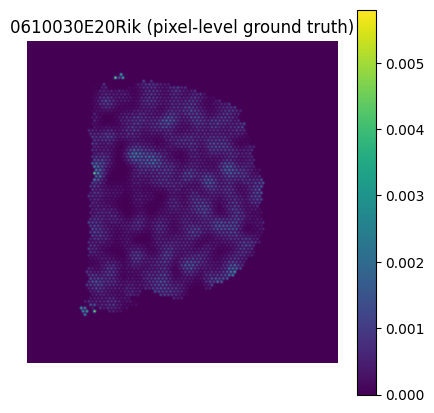

In [ ]:
# Sanity check plot for a single gene
import matplotlib.pyplot as plt

if len(genes_for_pixels) > 0:
    gene_idx = 0  # index into genes_for_pixels
    gname = genes_for_pixels[gene_idx]

    plt.figure(figsize=(5, 5))
    plt.imshow(pixel_maps[:, :, gene_idx], cmap="viridis")
    plt.title(f"{gname} (pixel-level ground truth)")
    plt.axis("off")
    plt.colorbar()
    plt.show()


In [9]:
type(adata)

anndata._core.anndata.AnnData

In [10]:
# Save for Starfysh

# Save processed AnnData (with *_heat3 features)
adata.write_h5ad("../data/visium_mouse_brain_heat.h5ad")

# Save H&E image
np.save("../data/visium_mouse_brain_img.npy", img_np)

# Save pixel × gene maps + corresponding gene names
np.save("../data/visium_mouse_brain_pixel_gene_maps.npy", pixel_maps)
np.save("../data/visium_mouse_brain_pixel_gene_names.npy", np.array(genes_for_pixels))

print("Saved h5ad, image, and pixel×gene maps.")


Saved h5ad, image, and pixel×gene maps.


In [13]:
import numpy as np
from scipy.stats import pearsonr

gene = genes_for_pixels[0]          # same gene you plotted
col  = f"{gene}_heat3"

# 1) spot-level diffused values
spot_vals = adata.obs[col].to_numpy()

# 2) spot coordinates in pixel space
coords = np.asarray(adata.obsm[spatial_key], dtype=float)[:, :2]
xy_pix = coords * float(s_hires)

# 3) sample pixel map at spot centers
gene_idx = 0  # index of the gene in pixel_maps
H, W = pixel_maps.shape[:2]
pixel_samples = []
for (x, y) in xy_pix:
    ix = int(round(x))
    iy = int(round(y))
    if 0 <= ix < W and 0 <= iy < H:
        pixel_samples.append(pixel_maps[iy, ix, gene_idx])
    else:
        pixel_samples.append(np.nan)

pixel_samples = np.array(pixel_samples)

# 4) drop NaNs and compute correlation
mask = ~np.isnan(pixel_samples)
r, _ = pearsonr(spot_vals[mask], pixel_samples[mask])
print("Pearson r between spot_heat3 and pixel samples:", r)


Pearson r between spot_heat3 and pixel samples: 0.9999999913296552


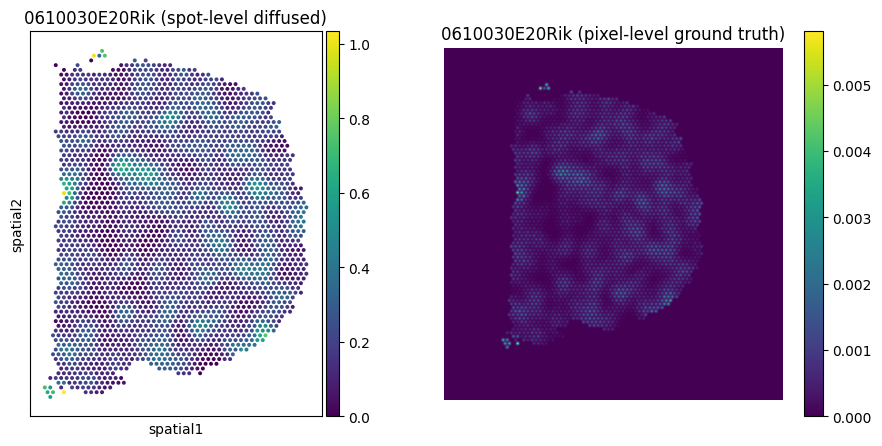

In [19]:
import matplotlib.pyplot as plt

gene = genes_for_pixels[0]
gidx = 0
col = f"{gene}_heat3"

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Left: spot-level diffused
sq.pl.spatial_scatter(
    adata,
    color=col,
    img=None,
    spatial_key=spatial_key,
    size=50,
    ax=axes[0]
)

axes[0].set_title(f"{gene} (spot-level diffused)")

# Right: pixel-level
im = axes[1].imshow(pixel_maps[:, :, gidx], cmap="viridis")
axes[1].set_title(f"{gene} (pixel-level ground truth)")
axes[1].axis("off")
fig.colorbar(im, ax=axes[1])

plt.show()
